# Trabalho Unidade 02 - Spotify Million Playlist Dataset

Autores:

* Darlan de Castro Silva Filho - 20200000607;
* Marcos Henrique Fernandes Marcone - 20200000760;

Disciplina: IMD1155 - ANÁLISE DE REDES - T01 (2021.2)

Professor: Ivanovitch Medeiros Dantas da Silva

## Spotify Million Playlist Dataset


O **Spotify Million Playlist Dataset Challenge** consiste em um conjunto de dados e avaliação para permitir pesquisas em recomendações de músicas. É uma continuação do **RecSys Challenge 2018**, que decorreu de janeiro a julho de 2018. O conjunto de dados contém **1.000.000 playlists**, incluindo títulos de playlists e títulos de faixas, criadas por usuários na plataforma Spotify entre janeiro de 2010 e outubro de 2017. 

Fonte: [Spotify Million Playlist Dataset Challenge](https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge)

In [ ]:
# Instalando o nxviz e o networkx
!pip install nxviz==0.6.3 networkx

In [ ]:
# Montando o Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importação das bibliotecas que serão utilizadas durante a análise
import json
import pandas as pd
from tqdm import tqdm 
import networkx as nx
import nxviz
from nxviz.plots import CircosPlot
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
import os, random

In [ ]:
# Caminho para os arquivos no drive
PATH_ARQUIVOS = '/content/drive/MyDrive/2021.2/Análise de Redes/Trabalho 2 Unidade/datasetsExtraidos/spotify_million_playlist_dataset.zip (Unzipped Files)/data'
PATH_GRAPHML = '/content/drive/MyDrive/2021.2/Análise de Redes/Trabalho 2 Unidade/playlists_artists.graphml'

### Organização do dataset

O dataset originalmente possui os seguintes campos:
* **name:** nome da playlist;
* **collaborative:** se a playlist é colaborativa ou não;
* **pid:** id da playlist; 
* **modified_at:** quando foi modificado, horário UNIX;
* **num_tracks:** número de músicas presente na playlist;
* **num_followers:** número de seguidores da playlist;
* **tracks:** campo com informações das faixas musicais;
* **num_edits:** quantidade de edições;
* **duration_ms:** tempo total da playlist em *ms*;
* **num_artists:** número de artistas na playlist;
* **description:** descrição da playlist;

Dentro todos esses campos, o que de fato é utilizado é o **track**. É nele em estão presentes as faixas musicais que formam a playlist. Para cada faixa musical é possível encontrar as seguintes informações

* **album_name**: nome do álbum;
* **album_uri:** endereço URI do álbum;
* **artist_name:** nome do artista;
* **artist_uri:** endereço URI do artista;
* **duration_ms:** duração da música;
* **pos:** posição da música na playlist;
* **track_name:** nome da música;
* **track_uri:** endereço URI da música;

Originalmente, o dataset fornecido pelo desafio é formado por **1000 arquivos** em que cada arquivo há **1000 playlists**. Como o dataset é muito grande e extenso, utilizá-lo por completo tornaria a análise muito complexa e demorada, assim como faltaria poder computacional.


Dessa forma optou-se por pegar uma amostra do dataset em que se pegou **2 arquivos** aleatoriamente e em cada arquivo foram selecionadas **250 playlists**.



In [ ]:
# Seleção pseudo randomica de arquivos para análise
NUMERO_DE_ARQUIVOS = 2
listaDeArquivos = random.sample(os.listdir(PATH_ARQUIVOS), NUMERO_DE_ARQUIVOS)
print("Arquivos utilizados:")
print(listaDeArquivos)

Arquivos utilizados:
['mpd.slice.487000-487999.json', 'mpd.slice.424000-424999.json']


## Grafo

O grafo a ser gerado é **não-direcionado** e **ponderado**. Em que os nós são os **artistas**, e eles são ligados através de uma aresta se aparecem em uma mesma playlist. Já o peso das arestas representa a quantidade de vezes em que os artistas apareceram juntos contando todas as playlists. Assim as arestas podem ser entendidas como a frequência em que dois artistas distintos aparecem em uma playlist. 

A fim de simplificar o grafo gerado através da leitura das playlists são feitos alguns filtros. Primeiramente, remove-se os self-loops, que são arestas que saem e incidem sobre um mesmo nó. Em seguida, busca-se extrair o **GCC (Giant Connected Component)** para se ter a garantia de uma rede conectada. Por fim, para tentar diminuir o tamanho da rede busca-se eliminar os nós que possuem o grau igual 1, ou seja apenas uma ligação.

In [ ]:
# Inicialização do grafo
#g = nx.Graph()
g = nx.read_graphml(PATH_GRAPHML)

In [ ]:
# Povoamento do grafo com os dados dos arquivos previamente selecionados
QUANTIDADE_PLAYLISTS_POR_ARQUIVO = 250
for arquivoAtual in tqdm(listaDeArquivos):
  arquivoFormatado = json.load(open(os.path.join(PATH_ARQUIVOS, arquivoAtual)))
  for playlist in random.sample(arquivoFormatado["playlists"], QUANTIDADE_PLAYLISTS_POR_ARQUIVO):
    artistas = []
    for musica in playlist['tracks']:
      artistaFormatado = musica['artist_name'].replace("$","S")
      artistas.append(artistaFormatado) 
      if not g.has_node(artistaFormatado):
        g.add_node(artistaFormatado)
    for i, artistaBase in enumerate(artistas):
      for j, artistaComparacao in enumerate(artistas):
        if i >= j:
          continue
        if g.has_edge(artistaBase, artistaComparacao):
          g[artistaBase][artistaComparacao]['weight'] += 1
        else:
          g.add_edge(artistaBase, artistaComparacao, weight=1)

100%|██████████| 2/2 [00:06<00:00,  3.04s/it]


In [ ]:
# Informações da rede
numeroDeNos = g.number_of_nodes()
numeroDeArestas = g.number_of_edges()
print('Número de nós:', numeroDeNos)
print('Número de arestas:', numeroDeArestas)

Número de nós: 6619
Número de arestas: 512624


In [ ]:
# Verificando se o grafo é conectado
print("Grafo eh conectado?", nx.is_connected(g))
print("Número de componentes conectadas", nx.number_connected_components(g))

Grafo eh conectado? True
Número de componentes conectadas 1


In [ ]:
# Remove todas as arestas que estão em loop consigo mesma
g.remove_edges_from(nx.selfloop_edges(g))

In [ ]:
# (OPCIONAL) Se o grafo g não for conectado pode-se atualizar o g com a maior componente conectada do grafo original
gcc = sorted(nx.connected_components(g), key=len, reverse=True)
novoG = g.subgraph(gcc[0])
g = novoG

In [ ]:
# Informações do GCC
numeroDeNos = g.number_of_nodes()
numeroDeArestas = g.number_of_edges()
print('Número de nós:', numeroDeNos)
print('Número de arestas:', numeroDeArestas)

Número de nós: 6619
Número de arestas: 510514


In [ ]:
# Conta a quantidade de nós que não tem um grau mínimo
grauMinimo = 1 # Nós com grau 1
grausParaRemover = [no for no, grau in dict(g.degree()).items() if grau < grauMinimo]
print('Existem {} nó(s) que não contém o grau mínimo de "{}"'.format(len(grausParaRemover), grauMinimo))

Existem 0 nó(s) que não contém o grau mínimo de "1"


In [ ]:
# (OPCIONAL) Remove os nós que não contém o grau mínimo
g.remove_nodes_from(grausParaRemover)

In [ ]:
print("A rede foi reduzida em", str(((numeroDeNos - g.number_of_nodes()) / numeroDeNos) * 100), "%")

A rede foi reduzida em 0.0 %


In [ ]:
# Exporta a rede no formato .graphml
nx.write_graphml(g, "playlists_artists.graphml")

Ao final, com a amostra selecionada a rede ficou com:

* 6619 nós;
* 510514 arestas.

## Análise de dados

Esta seção apresenta as seguintes análises em relação à rede:

 * Excentricidade, diâmetro, periferia, raio e centro;
 * Degree, Closeness, Betweenness and Eigenvector Centrality;

Para cada métrica são apresentadas imagens da rede, assim como são listados os **Top 10** vértices.

Além disso, são apresentadas análides bivariadas e multivariadas para todos os tipos de centralidade.

Por fim é realizada a decomposição da rede em que se obtém os 2 k-cores mais profundos.

**OBS:** **é preciso destacar que apesar de ser um grafo ponderado, para o cálculo de todas as métricas não foram considerados os pesos das arestas. Isso foi feito para tornar os cálculos e as interpretações mais simples.**

In [ ]:
# Spring Layout
pos = nx.spring_layout(g, seed=123456, k=0.5)

### Excentricidade 

In [ ]:
# Excentricidade Normalizada da Rede
eccentricity = nx.eccentricity(g)

#### Gráfico

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  app.launch_new_instance()


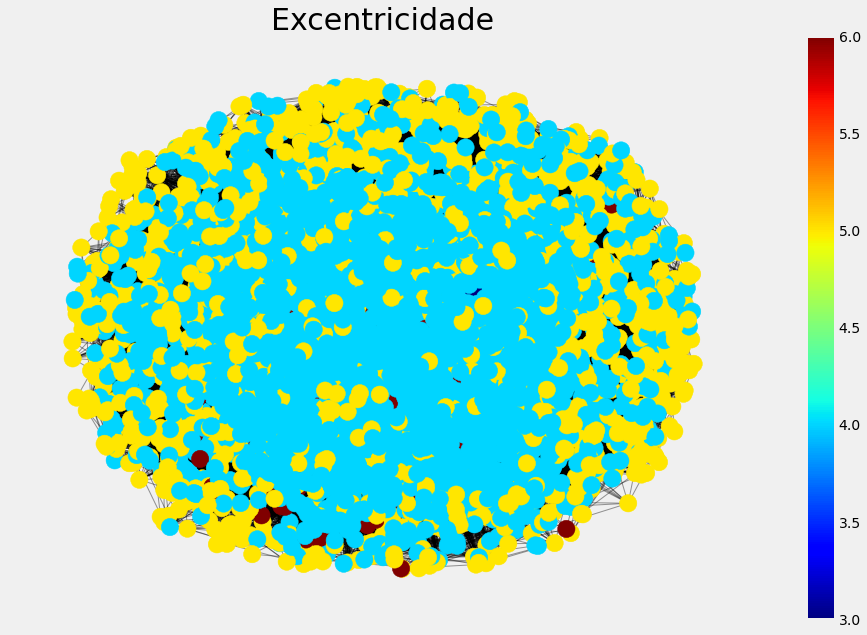

In [ ]:
# Excentricidade
fig, ax = plt.subplots(1,1,figsize=(15,10))
color = list(dict(eccentricity).values())
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=0.4, ax=ax)
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,ax=ax)
plt.title("Excentricidade", fontsize = 30)
plt.axis("off")
plt.colorbar(nodes)
plt.show()


Analisando o gráfico de excentricidade da rede nota-se que existe uma grande quantidade de nós com a tonalidade azul claro, indicando que o seu maior menor caminho em relação aos outros nós está em torno de quatro arestas. Mas além disso há uma quantidade considerável de nós com uma cor amarelada representando uma excentricidade em torno de cinco. Também nota-se que há nós, em menor quantidade, com um tom vermelho bem escuro simbolizando os nós com excentricidade igual a 6. 

#### Diâmetro

In [ ]:
# Diâmetro da Rede
diametro = nx.diameter(g)
print("Diâmetro da rede: {}".format(diametro))

Diâmetro da rede: 6


O diâmetro da rede é 6, representado que a maior excentricidade entre dois nós dessa rede possui 6 arestas.

#### Periferia

In [ ]:
periferia = nx.periphery(g)
print("Comprimento da periferia: {}".format(len(periferia)))
print("Periferia da rede: {}".format(periferia))

Comprimento da periferia: 67
Periferia da rede: ['MF DOOM', 'King Geedorah', 'Viktor Vaughn', 'Madvillain', 'Monsta Island Czars', 'Doom', 'Count Bass D', 'Masta Killa', 'Ghostface Killah', 'Ghostface Killah & Doom', 'Scienz Of Life', 'Zeno', 'Hymns on Piano', 'Mezzo Piano', 'GameChap', 'Approaching Nirvana', 'Bobby Yarsulik', 'Brad Knauber', 'Brad Knauber, Pedro Esparza & Vareide', 'Bryan "BrySi" Simon', 'Captainsparklez', 'Dreamreaver23', 'Kenneth Estrada & Santiago', 'Ozo', 'Phantaboulous', 'Steve Duzz', 'Tryhardninja', 'Togun', 'Element Animation', 'Yomamasminecraft', 'J.T. Machinima', 'ThnxCya', 'Eric Fullerton', 'Inthelittlewood', 'Exeria', 'Sentinus', '2 AM', 'Skydoesminecraft', 'Boyinaband', "Jolly Ol' Brits", 'Deebri Music', 'Patient Zero', 'Dan Bull', 'Toby Turner & Tobuscus', 'BrainForce V', 'JT Music', 'OMFG', 'Justin Brandl', 'Cawkav', 'Rosie Jones', 'Minecraft Jams', 'J Rice', 'Dab Music', 'Dmp Music', 'CavemanFilms', 'MC Jams', 'MR MEOLA', 'ShadyVox', 'Zach Boucher', 'Li

A periferia da rede é formada por **67** nós, indicando que esses nós possuem excentricidade igual a 6.


#### Raio

In [ ]:
raio = nx.radius(g)
print("Raio da rede: {}".format(raio))

Raio da rede: 3


O raio da rede é 3, representado que a menor excentricidade entre dois nós dessa rede possui 3 arestas.

Por fim, é importante notar que apesar de ser uma rede com mais de 6000 nós e 500000 arestas, o raio e o diâmetro da rede são extremamente pequenos, representado que os nós estão bem próximo um dos outros.

#### Centro

In [ ]:
centro = nx.center(g)
print("Comprimento do centro: {}".format(len(centro)))
print("Centro da rede: {}".format(centro))

Comprimento do centro: 32
Centro da rede: ['Of Monsters and Men', 'OneRepublic', 'Bastille', 'Weezer', 'Ed Sheeran', 'The Chainsmokers', 'Hailee Steinfeld', 'Kygo', 'Who Is Fancy', 'Andy Grammer', 'Ray LaMontagne', 'Jon Bellion', 'gnash', 'X Ambassadors', 'Relient K', 'Portugal. The Man', 'Mac Miller', 'Amber Run', 'Karmin', 'Cobi', 'Wild Child', 'The Wombats', 'Lauv', 'Noah Cyrus', 'Vice', 'NEEDTOBREATHE', 'Demi Lovato', 'for KING & COUNTRY', 'Glee Cast', 'Sufjan Stevens', 'The Piano Guys', 'Lauren Daigle']


O centro da rede é formada por **32** nós, indicando que esses nós possuem excentricidade igual a 3.


### Degree Centrality

In [ ]:
# Degree Centrality
degree = nx.degree_centrality(g)

In [ ]:
# Gera uma sequência decrescente dos graus dos nós
degreeOrdenados = sorted(degree, key=degree.get, reverse=True)

In [ ]:
# Gera uma sequência decrescente dos graus dos nós
grausNos = [g.degree(artista) for artista in degreeOrdenados]

#### Gráfico

Calculating
Ploting...


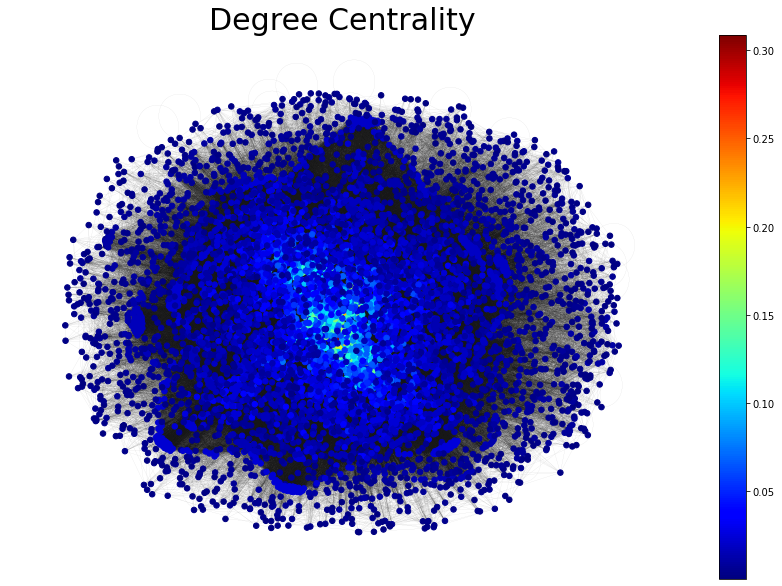

In [ ]:
# Degree centrality
fig, ax = plt.subplots(1,1,figsize=(15,10))
print("Calculating")
color = list(dict(degree).values())
print("Ploting...")
nx.draw_networkx_edges(g,
                       pos=pos, width=0.05,
                       alpha=0.6, ax=ax)
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax,node_size=30)
plt.title("Degree Centrality", fontsize = 30)
plt.axis("off")
plt.colorbar(nodes)

Analisando o gráfico para o Degree Centrality nota-se que a grande maioria dos nós está conectada a outros pouquíssimos nós ao se comparar com a quantidade de vértices presentes na rede. Por isso o Degree Centrality concentra-se num valor em torno de 0.05. Ainda assim, há uma pequena quantidade de nós que se destacam em relação ao seu grau.

#### Top 10 vértices

In [ ]:
print('Top 10 vértices:')
i = 0
for artista in degreeOrdenados:
  if i == 10:
    break
  print("{:^20} {:5.4f} {:5}".format(artista, degree[artista], g.degree(artista)))
  i += 1

Top 10 vértices:
      Rihanna        0.3081  2039
  The Chainsmokers   0.3061  2026
       Drake         0.3043  2014
     Kanye West      0.3031  2006
   Calvin Harris     0.2578  1706
     The Weeknd      0.2436  1612
   Kendrick Lamar    0.2392  1583
    Major Lazer      0.2387  1580
      Coldplay       0.2366  1566
     Bruno Mars      0.2274  1505


Analisando os Top 10 vértices observa-que o nó que possui o maior grau, que é de 2039, ainda está muito distante da quantidade de nós da rede que é em torno de 6000. Dessa forma, percebe-se que há uma grande variedade de artistas nas playlists e que eles não se repetem num grau tão grande.

#### Análise Bivariada

##### PDF (Probability Density Function)

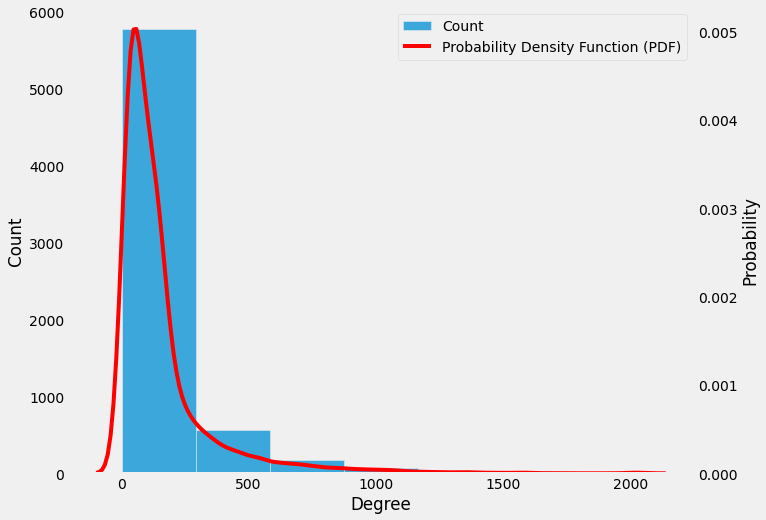

In [ ]:
# Análise bivariada degree centrality
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,1,figsize=(10,8))
sns.histplot(grausNos, bins=7, label="Count",ax=ax)
ax2 = ax.twinx()
sns.kdeplot(grausNos, color='r',label="Probability Density Function (PDF)",ax=ax2)
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
ax.grid(False)
ax2.grid(False)
ax.set_xlabel("Degree")
ax2.set_ylabel("Probability")
plt.show()

A Função de Densidade de Probabilidade confirma o que foi apresentado anteriormente com uma esmagadora maioria dos nós com o grau em torno de 0 a 250. Pouquíssimos são os nós que possuem um grau superior a 1000.




##### CDF (Cumulative Density Function)

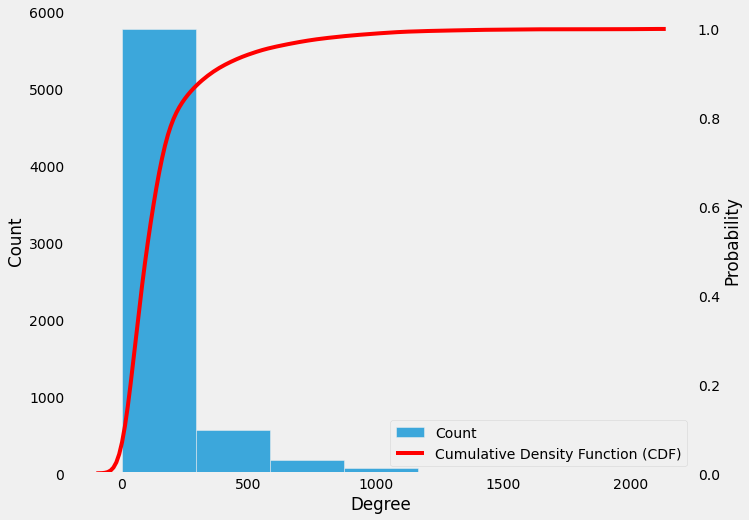

In [ ]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,1,figsize=(10,8))
sns.histplot(grausNos,bins=7,label="Count",ax=ax)
ax2 = ax.twinx()
sns.kdeplot(grausNos,color='r',label="Cumulative Density Function (CDF)",ax=ax2,cumulative=True)
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
ax.grid(False)
ax2.grid(False)
ax.set_xlabel("Degree")
ax2.set_ylabel("Probability")
plt.show()

Com a análise com Função de Densidade Cumulativa percebe-se que a probabilidade cresce muito rápido de 0 a 0.95 com o grau dos nós de concentrando em 0 a 250. 

Ou seja, ao escolher um artista nessa rede é muito provável que o seu grau seja pequeno. Isso é mais um argumento que reforça a diversidade dos artistas que compõem as playlists. 

### Closeness Centrality

In [ ]:
closeness = nx.closeness_centrality(g)

In [ ]:
# Gera uma sequência decrescente da closeness centrality dos nós
closenessOrdenados = sorted(closeness, key=closeness.get, reverse=True)

In [ ]:
closenessNos = [closeness[artista] for artista in closenessOrdenados]

#### Gráfico

Calculating
Ploting...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


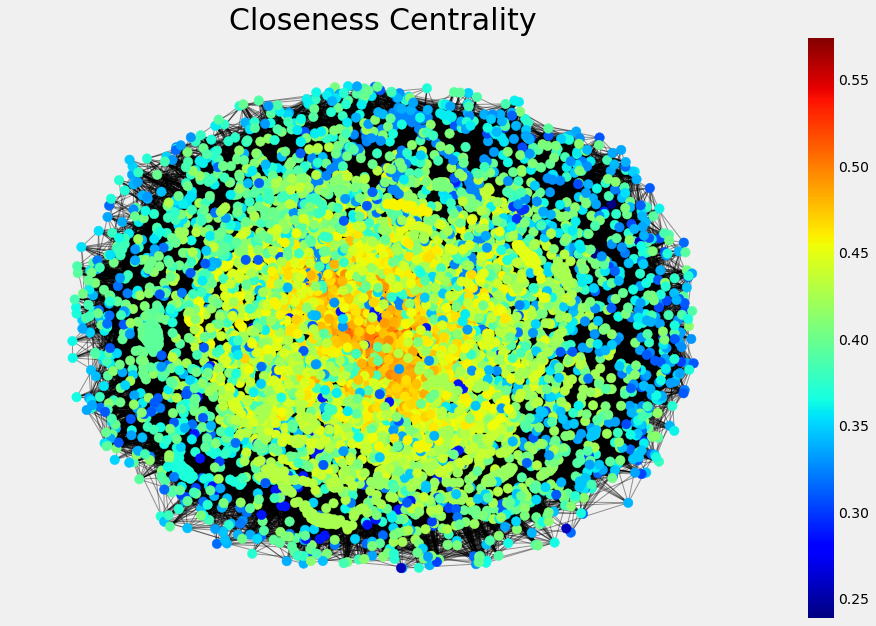

In [ ]:
# Closeness centrality
fig, ax = plt.subplots(1,1,figsize=(15,10))
print("Calculating")
color = list(dict(closeness).values())
print("Ploting...")
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=0.4, ax=ax)
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax,node_size=90)

plt.title("Closeness Centrality", fontsize = 30)
plt.axis("off")
plt.colorbar(nodes)

Analisando o gráfico para o Closeness Centrality nota-se que há uma grande diversidade nos valores. Percebe-se que a grande maioria dos nós possui um  Closeness Centrality em torno de 0.4 a 0.45, o que é um valor bem alto considerando o tamanho da rede. 

Nota-se também nós com um  Closeness Centrality próximo a 0.3, principalmente aqueles que estão mais nas extremidades. Assim como, no centro há nós com um valor superior a 0.5.

#### Top 10 vértices

In [ ]:
print('Top 10 vértices:')
i = 0
for artista in closenessOrdenados:
  if i == 10:
    break
  print("{:^20} {:5.4f}".format(artista, closeness[artista]))
  i += 1

Top 10 vértices:
      Rihanna        0.5753
     Kanye West      0.5728
  The Chainsmokers   0.5718
       Drake         0.5682
   Calvin Harris     0.5552
   Kendrick Lamar    0.5528
      Coldplay       0.5474
      Beyoncé        0.5458
     Bruno Mars      0.5452
     Ed Sheeran      0.5449


Observando os **Top 10** vértices com maiores  Closeness Centrality, nota-se um valor superior a 0.54 chegando até 0.57.

Esses são valores notáveis para uma rede de 6000 nós.

#### Análise Bivariada

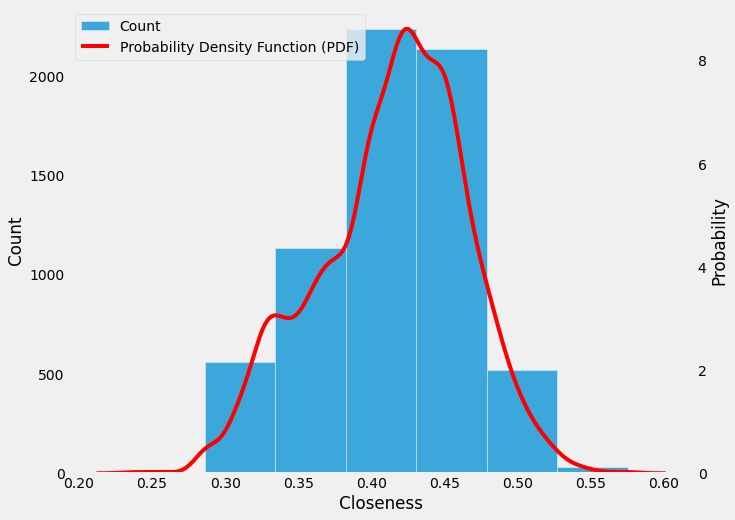

In [ ]:
# Análise bivariada closeness centrality
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,1,figsize=(10,8))
sns.histplot(closenessNos,bins=7,label="Count",ax=ax)
ax2 = ax.twinx()
sns.kdeplot(closenessNos,color='r',label="Probability Density Function (PDF)",ax=ax2)
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
ax.grid(False)
ax2.grid(False)
ax.set_xlabel("Closeness")
ax2.set_ylabel("Probability")
plt.show()

Por fim, a Função de Densidade de Probabilidade confirma o que foi apresentado anteriormente com uma concentração do valor do Closeness Centrality em torno de 0.4 a 0.45.

É preciso ressaltar o significado dessa métrica, assim nota-se que os nós estão muito próximos aos outros, sendo o caminho mais curto em torno de 4 arestas. 

Ou seja ao escolher dois artistas distindos há uma alta probabilidade que a distância entre eles seja de 4 arestas.

### Betweenness Centrality

In [ ]:
betweenness = nx.betweenness_centrality(g)

In [ ]:
# Gera uma sequência decrescente da betweenness centrality dos nós
betweennessOrdenados = sorted(betweenness, key=betweenness.get, reverse=True)

In [ ]:
betweennessNos = [betweenness[artista] for artista in betweennessOrdenados]

#### Gráfico

Calculating
Ploting...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  app.launch_new_instance()


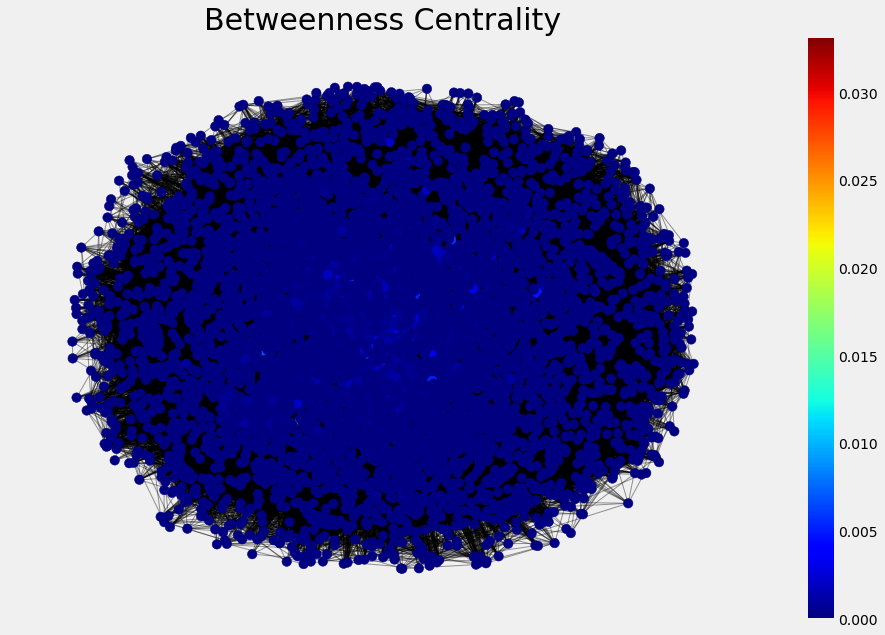

In [ ]:
# Betweenness centrality
fig, ax = plt.subplots(1,1,figsize=(15,10))
print("Calculating")
color = list(dict(betweenness).values())
print("Ploting...")
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=0.4, ax=ax)
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax,node_size=90)
plt.title("Betweenness Centrality", fontsize = 30)
plt.axis("off")
plt.colorbar(nodes)
plt.show()

âPara a métrica de Betweenness Centrality o grafo indica uma predominância quase unânime de valores menores que 0.01. Isso indica que os nós não estão bem posicionados entre os caminhos mais curtos entre os nós do grafo.


#### Top 10 vértices

In [ ]:
print('Top 10 vértices:')
i = 0
for artista in betweennessOrdenados:
  if i == 10:
    break
  print("{:^30} {:5.4f}".format(artista, betweenness[artista]))
  i += 1

Top 10 vértices:
       Various Artists         0.0332
          Kanye West           0.0193
           Rihanna             0.0192
         Major Lazer           0.0178
       The Chainsmokers        0.0166
        Pedro Esparza          0.0150
            Drake              0.0148
   Bob Marley & The Wailers    0.0136
        Kendrick Lamar         0.0134
          Ed Sheeran           0.0111


No Top 10 vértices o intervalo de variação se posiciona entre 0.033 e 0.011. Com o valor inferior se posicionando muito próximo da moda aparente do grafo para essa métrica é percebida uma grande uniformidade entre os nós.


#### Análise Bivariada

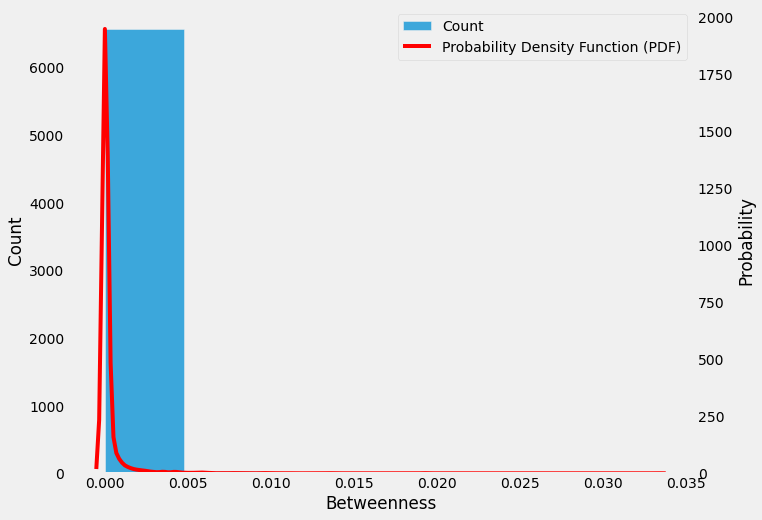

In [ ]:
# Análise bivariada betweenness centrality
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,1,figsize=(10,8))
sns.histplot(betweennessNos,bins=7,label="Count",ax=ax)
ax2 = ax.twinx()
sns.kdeplot(betweennessNos,color='r',label="Probability Density Function (PDF)",ax=ax2)
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
ax.grid(False)
ax2.grid(False)
ax.set_xlabel("Betweenness")
ax2.set_ylabel("Probability")
plt.show()

A Análise Bivariada confirma o que foi percebido anteriormente, com quase todas as amostras se posicionando até 0.005 é perceptível a uniformidade dessa métrica através dos nós. O que indica que os nós, em geral, não são bem posicionados entre os caminhos mais curtos de dois nós aleatórios. Ou seja, não há um nó que concentra o fluxo da informação.


### Eigenvector Centrality

In [ ]:
eigenvector = nx.eigenvector_centrality(g)

In [ ]:
# Gera uma sequência decrescente da eigenvector centrality dos nós
eigenvectorOrdenados = sorted(eigenvector, key=eigenvector.get, reverse=True)

In [ ]:
eigenvectorNos = [eigenvector[artista] for artista in eigenvectorOrdenados]

#### Gráfico

Calculating
Ploting...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


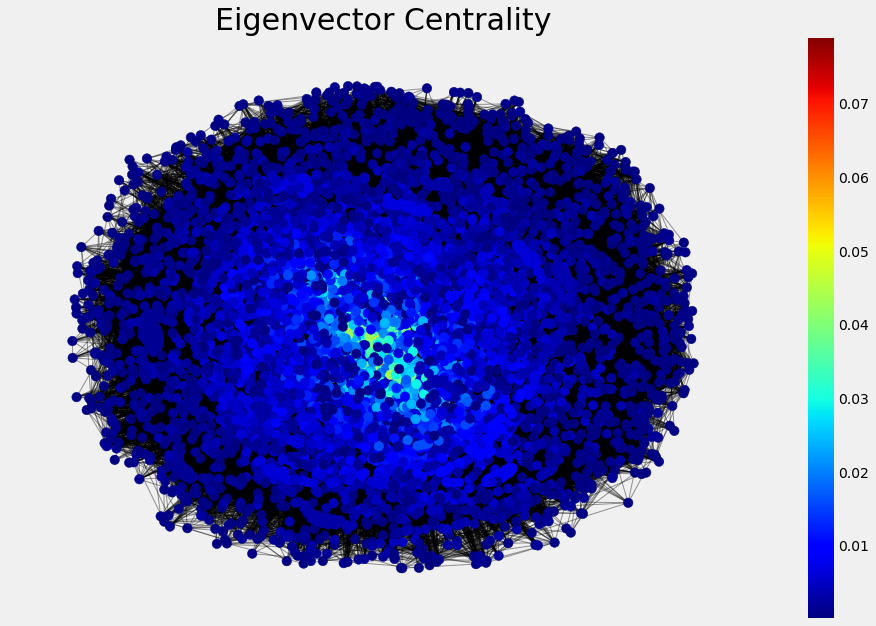

In [ ]:
# Eigenvector centrality
fig, ax = plt.subplots(1,1,figsize=(15,10))
print("Calculating")
color = list(dict(eigenvector).values())
print("Ploting...")
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=0.4, ax=ax)
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax,node_size=90)
plt.title("Eigenvector Centrality", fontsize = 30)
plt.axis("off")
plt.colorbar(nodes)
plt.show()

Analisando o gráfico para o Eigenvector Centrality nota-se que a grande maioria dos nós tem valores muito baixos para essa métrica, o que indica que os nós, em geral, não tem conexões com nós importantes. Por isso o Eigenvector Centrality concentra-se num valor em torno de 0.01. Existe, ainda, uma pequena quantidade de nós que se destacam nessa métrica (chegam a 0.079).


#### Top 10 vértices

In [ ]:
print('Top 10 vértices:')
i = 0
for artista in eigenvectorOrdenados:
  if i == 10:
    break
  print("{:^20} {:5.4f}".format(artista, eigenvector[artista]))
  i += 1

Top 10 vértices:
      Rihanna        0.0792
  The Chainsmokers   0.0777
       Drake         0.0776
     Kanye West      0.0755
   Calvin Harris     0.0711
     The Weeknd      0.0687
     Bruno Mars      0.0684
       G-Eazy        0.0681
      Maroon 5       0.0668
      Beyoncé        0.0644


Analisando os Top 10 vértices observa-se que os nós possuem valores relativamente altos (0.07) se comparados com a moda (0.01). Dessa forma, percebe-se que há um nicho de nós importantes que se conectam entre si.


#### Análise Bivariada

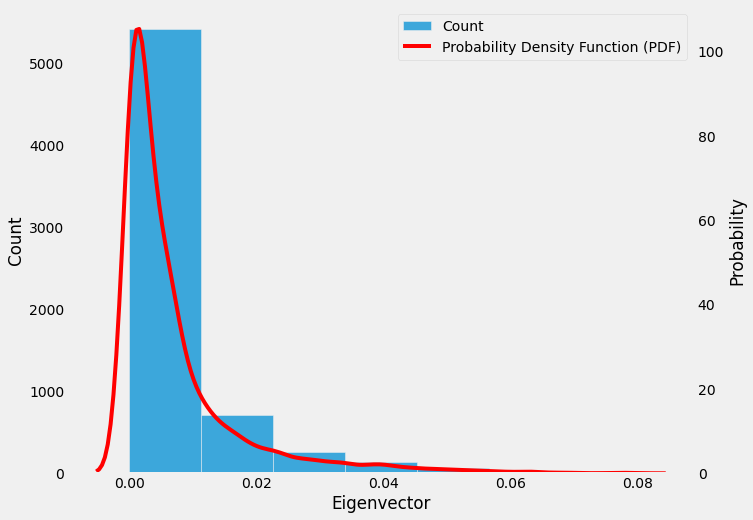

In [ ]:
# Análise bivariada eigenvector centrality
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,1,figsize=(10,8))
sns.histplot(eigenvectorNos, bins=7, label="Count", ax=ax)
ax2 = ax.twinx()
sns.kdeplot(eigenvectorNos,color='r',label="Probability Density Function (PDF)",ax=ax2)
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
ax.grid(False)
ax2.grid(False)
ax.set_xlabel("Eigenvector")
ax2.set_ylabel("Probability")
plt.show()

Já para o gráfico de Análise Bivariada é visível que a moda da métrica Eigenvector Centrality se concentra em valores que vão de 0 à 0.01, como já era esperado. Ainda existem algumas amostras visíveis até 0.04 mas após isso é bem escasso a quantidade de nós (de 0.04 à 0.07).


### Gráfico com as quatro métricas de centralidade

### Análise Multivariada

In [ ]:
bc = pd.Series(betweenness)
dc = pd.Series(degree)
ec = pd.Series(eigenvector)
cc = pd.Series(closeness)
df = pd.DataFrame.from_dict({"Betweenness": bc,
                            "Degree": dc,
                            "EigenVector": ec,
                            "Closeness": cc})
df.reset_index(inplace=True, drop=True)
df.sample()

,Betweenness,Degree,EigenVector,Closeness
5797,0.0,0.006044,0.000031,0.328469


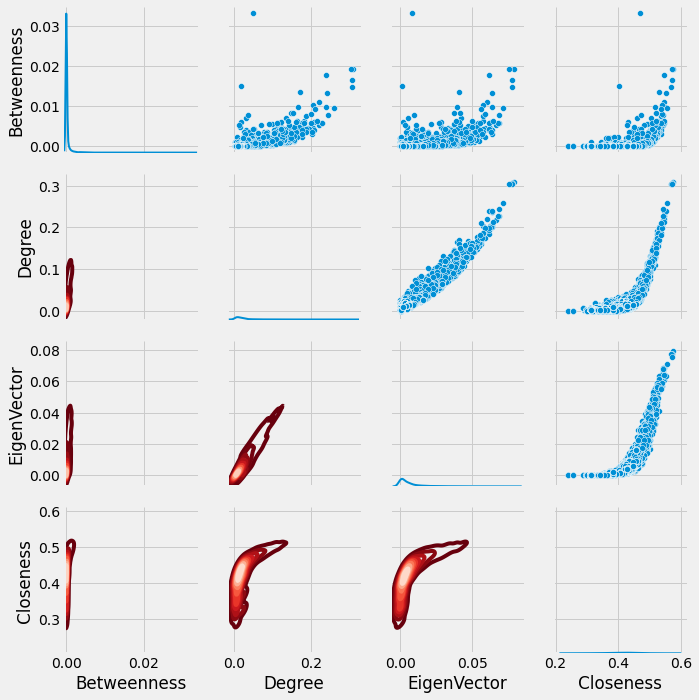

In [ ]:
fig = sns.PairGrid(df)
fig.map_upper(sns.scatterplot)
fig.map_lower(sns.kdeplot, cmap="Reds_r")
fig.map_diag(sns.kdeplot, lw=2, legend=False)
plt.show()

Analisando o gráfico das relações multivariadas os seguintes pontos podem ser destacados:
* Primeiramente ao relacionar o eigenvector centrality de um nó com seu grau nota-se que quanto mais importante for esse nó, maior será o seu grau, sendo essa relação, linear;
* Outra relação interessante está ao associar o Closeness Centrality com o Eigenvector Centrality e o Degree Centrality. Em ambos os caso, quanto maior for o valor do Closeness Centrality, maiores serão essas duas outras métricas. Os gráficos possuem um comportamento bem próximo ao exponencial. Isso significa que quanto mais próximo um nó estiver em relação a todos os outros nós, maior será o seu grau e maior será a sua importância;
* Em relação aos outros gráficos não foi possível inferir alguma conclusão em relação às métricas analisadas. Não foi possível determinar um comportamento bem definido

### Análise Decomposição da Rede 2 k-cores mais profundos

Um k-core em uma rede é um sub-grafo de nós com um mínimo de k conexões entre eles. Esses sub-grafos são conjuntos de nós super conectados entre si.


In [ ]:
# Agrupar Kcores do grafo
kcores = list(set([v for k,v in nx.core_number(g).items()]))

#### Listar os 2 k-cores mais profundos

In [ ]:
nosUltimoKCore = [node for node in list(nx.k_core(g, kcores[-1]))]
nosPenultimoKCore = [node for node in list(nx.k_core(g, kcores[-2]))]

O k-core mais profundo é composto por 406 nós com uma profundidade de 178.

In [ ]:
print("Profundidade do último k-core:", kcores[-1])
print("Quantidade de nós no último k-core:", len(nosUltimoKCore))
print("Nós no último k-core:")
print(nosUltimoKCore)

Profundidade do último k-core: 178
Quantidade de nós no último k-core: 406
Nós no último k-core:
['Post Malone', 'One Direction', 'Lady Gaga', 'OneRepublic', 'Weezer', 'Kelis', 'Gavin DeGraw', 'Machine Gun Kelly', 'Elle King', 'Wes Walker', 'Rihanna', 'Daft Punk', 'Maren Morris', 'Keith Urban', 'Keys N Krates', 'NEIKED', '21 Savage', 'The Fray', 'Felix Jaehn', 'Lil Uzi Vert', 'Juicy J', 'Jake Owen', 'Beyoncé', 'Nickelback', 'Maggie Lindemann', 'Nelly', 'Jess Glynne', 'The Black Eyed Peas', 'Marlon Roudette', 'French Montana', 'Logic', 'Starley', 'Kelly Clarkson', 'Mike Perry', 'Skrillex', 'Meek Mill', 'Christina Aguilera', 'B.o.B', 'Donnie Trumpet & The Social Experiment', 'Life of Dillon', 'KYLE', 'The Chainsmokers', 'Kelsea Ballerini', 'Katy Perry', 'Deorro', 'Third Eye Blind', "Guns N' Roses", 'Taylor Swift', 'Carrie Underwood', 'Yo Gotti', 'MAGIC!', 'Wale', 'Michael Jackson', 'Big Sean', 'Drake', 'J. Cole', 'Cage The Elephant', 'Jason Derulo', 'Gym Class Heroes', 'Coleman Hell', 'J

Já o penúltimo k-core é composto por 416 nós (10 novos nós além dos 406 do core mais profundo) com uma profundidade de 177.

In [ ]:
print("Profundidade do penúltimo k-core:", kcores[-2])
print("Quantidade de nós no penúltimo k-core:", len(nosPenultimoKCore))
print("Nós no penúltimo k-core:")
print(nosPenultimoKCore)

Profundidade do penúltimo k-core: 177
Quantidade de nós no penúltimo k-core: 416
Nós no penúltimo k-core:
['Post Malone', 'One Direction', 'Lady Gaga', 'OneRepublic', 'Weezer', 'Kelis', 'Gavin DeGraw', 'Machine Gun Kelly', 'Elle King', 'Wes Walker', 'Rihanna', 'Daft Punk', 'Maren Morris', 'Keith Urban', 'Keys N Krates', 'NEIKED', '21 Savage', 'The Fray', 'Felix Jaehn', 'Lil Uzi Vert', 'Juicy J', 'Jake Owen', 'Beyoncé', 'Nickelback', 'Maggie Lindemann', 'Nelly', 'Jess Glynne', 'The Black Eyed Peas', 'Marlon Roudette', 'French Montana', 'Logic', 'Starley', 'Kelly Clarkson', 'Mike Perry', 'Skrillex', 'Meek Mill', 'Christina Aguilera', 'B.o.B', 'Donnie Trumpet & The Social Experiment', 'Life of Dillon', 'KYLE', 'The Chainsmokers', 'Kelsea Ballerini', 'Katy Perry', 'Deorro', 'Third Eye Blind', "Guns N' Roses", 'Taylor Swift', 'Carrie Underwood', 'Yo Gotti', 'MAGIC!', 'Wale', 'Michael Jackson', 'Big Sean', 'Drake', 'J. Cole', 'Cage The Elephant', 'Jason Derulo', 'Gym Class Heroes', 'Coleman 

#### Gráfico com destaque para os 2 k-cores mais profundos

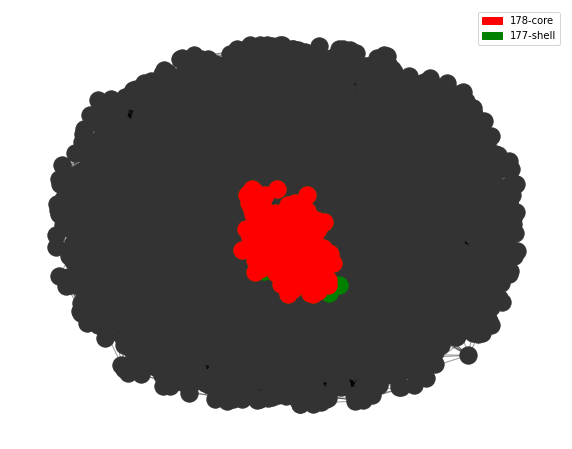

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=0.4, ax=ax)
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color="#333333")
nodes = nx.draw_networkx_nodes(nosPenultimoKCore,
                 pos=pos,
                 node_color="green")
nodes = nx.draw_networkx_nodes(nosUltimoKCore,
                 pos=pos,
                 node_color="red")
red_patch = mpatches.Patch(color='red', label=f'{kcores[-1]}-core')
green_patch = mpatches.Patch(color='green', label=f'{kcores[-2]}-shell')
plt.legend(handles=[red_patch, green_patch])
plt.axis("off")
plt.show()